In [2]:
#!/usr/bin/env python3
"""
Cross-domain cvPCA with random missingness between ViT embeddings and mouse brain responses.

Instead of a single deterministic SVD, we randomly mask out entries
in the brain representation (simulating held-out images), perform
alternating least squares to reconstruct them, and compute the
cross-domain covariance between ViT and reconstructed brain PCs.

This estimates how much of the ViT–Brain shared structure generalizes
to unseen data (cross-validated shared variance).

Author: Maria + Pläku 🐾
"""

import numpy as np
import pickle
from sklearn.decomposition import PCA
from scipy.special import softmax
from skbio.stats.composition import clr
from numpy.random import default_rng

# ---------------------------------------------------------------
# CONFIG
# ---------------------------------------------------------------
VIT_PATH    = '/home/maria/Documents/HuggingMouseData/MouseViTEmbeddings/google_vit-base-patch16-224_embeddings_logits.pkl'
NEURAL_PATH = '/home/maria/LuckyMouse/pixel_transformer_neuro/data/processed/hybrid_neural_responses.npy'
AREAS_PATH  = '/home/maria/MITNeuralComputation/visualization/brain_area.npy'
AREA_NAME   = 'VISp'      # e.g., VISp, VISam, VISpm...
N_IMAGES, N_TRIALS = 118, 50
VAR_CUTOFF  = 0.90
P_HOLDOUT   = 0.1          # fraction of held-out entries
RANDOM_SEED = 42
N_ITER      = 20           # ALS iterations
RANK        = 10           # number of components for cvPCA

rng = default_rng(RANDOM_SEED)

# ---------------------------------------------------------------
# STEP 1: ViT preprocessing
# ---------------------------------------------------------------
print("🔹 Loading ViT embeddings...")
with open(VIT_PATH, 'rb') as f:
    vit_logits = pickle.load(f)['natural_scenes']  # (images × D_vit)

Xv = softmax(np.asarray(vit_logits), axis=1)
Xv = clr(Xv + 1e-12)

vit_pca_full = PCA(random_state=RANDOM_SEED).fit(Xv)
vit_cumvar = np.cumsum(vit_pca_full.explained_variance_ratio_)
vit_ncomp = np.searchsorted(vit_cumvar, VAR_CUTOFF) + 1
vit_pca = PCA(n_components=vit_ncomp, random_state=RANDOM_SEED)
Zv = vit_pca.fit_transform(Xv)  # (images × vit_ncomp)
print(f"✅ ViT PCs covering 90% variance: {vit_ncomp}")

# ---------------------------------------------------------------
# STEP 2: Load brain data
# ---------------------------------------------------------------
print(f"🔹 Loading neural responses for {AREA_NAME}...")
dat = np.load(NEURAL_PATH, mmap_mode='r')
areas = np.load(AREAS_PATH, allow_pickle=True)
mask = (areas == AREA_NAME)
dat = dat[mask]

n_neurons, n_total = dat.shape
n_time = n_total // (N_IMAGES * N_TRIALS)
dat = dat.reshape(n_neurons, N_IMAGES, N_TRIALS, n_time)
X_mean = dat.mean(axis=(2,3))  # (neurons × images)

brain_pca_full = PCA(random_state=RANDOM_SEED).fit(X_mean.T)
brain_cumvar = np.cumsum(brain_pca_full.explained_variance_ratio_)
brain_ncomp = np.searchsorted(brain_cumvar, VAR_CUTOFF) + 1
brain_pca = PCA(n_components=brain_ncomp, random_state=RANDOM_SEED)
Zb = brain_pca.fit_transform(X_mean.T)  # (images × brain_ncomp)
print(f"✅ {AREA_NAME} PCs covering 90% variance: {brain_ncomp}")

# ---------------------------------------------------------------
# STEP 3: Random-mask cvPCA on brain representation
# ---------------------------------------------------------------
def censored_lstsq(A, B, M, lam=1e-6):
    """Least-squares solve for min_X ||M ⊙ (A X - B)||² + λ||X||²."""
    n, r = A.shape
    _, m = B.shape
    X = np.empty((r, m), dtype=B.dtype)
    I = np.eye(r, dtype=B.dtype)
    for j in range(m):
        mask = M[:, j]
        Aj = A[mask, :]
        bj = B[mask, j]
        T = Aj.T @ Aj + lam * I
        rhs = Aj.T @ bj
        X[:, j] = np.linalg.solve(T, rhs)
    return X

def random_mask_cvPCA(X, rank, p_holdout=0.1, n_iter=20, lam=1e-6, seed=0):
    """Perform cvPCA on X (n × m) with random missingness."""
    rng = default_rng(seed)
    n, m = X.shape
    M = rng.random((n, m)) > p_holdout

    # Initialize low-rank factors
    U = rng.standard_normal((n, rank)) / np.sqrt(n)

    for _ in range(n_iter):
        V = censored_lstsq(U, X, M, lam=lam)
        UT = censored_lstsq(V.T, X.T, M.T, lam=lam)
        U = UT.T

    U, _, _ = np.linalg.svd(U, full_matrices=False)
    V = U.T @ X
    recon = U @ V
    train_err = np.mean(((recon - X)[M]) ** 2)
    test_err = np.mean(((recon - X)[~M]) ** 2)
    return U, V, train_err, test_err, M

print("🔹 Running random-mask cvPCA on brain PCs...")
Ub, Vb, tr_err, te_err, M = random_mask_cvPCA(
    Zb.T, rank=RANK, p_holdout=P_HOLDOUT, n_iter=N_ITER, lam=1e-6, seed=RANDOM_SEED
)
print(f"✅ cvPCA done: train MSE={tr_err:.6f}, test MSE={te_err:.6f}")

# reconstructed brain representation (images × rank)
Zb_cv = (Ub @ Vb).T

# ---------------------------------------------------------------
# STEP 4: Cross-domain covariance on held-out entries
# ---------------------------------------------------------------
print("🔹 Computing cross-domain covariance (ViT ↔ reconstructed Brain)...")

# Center both
Zv -= Zv.mean(axis=0, keepdims=True)
Zb_cv -= Zb_cv.mean(axis=0, keepdims=True)

# Cross-covariance (ViT ↔ Brain)
C = (Zv.T @ Zb_cv) / Zv.shape[0]
Ucv, Scv, Vt_cv = np.linalg.svd(C, full_matrices=False)
shared_var = Scv**2 / np.sum(Scv**2)

# ---------------------------------------------------------------
# REPORT RESULTS
# ---------------------------------------------------------------
print("\n===== Random-mask cross-domain cvPCA results =====")
for i, (s, frac) in enumerate(zip(Scv, shared_var), 1):
    print(f"Component {i:2d}:  shared σ = {s:.4f}  |  fraction = {frac*100:.2f}%")

print(f"\n✅ Total shared variance across {len(Scv)} components = 100%")
print(f"Random mask holdout fraction = {P_HOLDOUT}")

# Save results
out_name = f"vit_{AREA_NAME}_cvpca_randommask_results.npz"
np.savez(out_name,
         singular_values=Scv,
         shared_fraction=shared_var,
         vit_basis=Ucv,
         brain_basis=Vt_cv.T,
         vit_scores=Zv,
         brain_scores=Zb_cv,
         mask=M)

print(f"💾 Saved to {out_name}")


🔹 Loading ViT embeddings...
✅ ViT PCs covering 90% variance: 44
🔹 Loading neural responses for VISp...
✅ VISp PCs covering 90% variance: 87
🔹 Running random-mask cvPCA on brain PCs...
✅ cvPCA done: train MSE=0.359750, test MSE=0.470004
🔹 Computing cross-domain covariance (ViT ↔ reconstructed Brain)...

===== Random-mask cross-domain cvPCA results =====
Component  1:  shared σ = 12.5695  |  fraction = 55.78%
Component  2:  shared σ = 7.6638  |  fraction = 20.74%
Component  3:  shared σ = 4.7439  |  fraction = 7.95%
Component  4:  shared σ = 3.6991  |  fraction = 4.83%
Component  5:  shared σ = 2.9598  |  fraction = 3.09%
Component  6:  shared σ = 2.6166  |  fraction = 2.42%
Component  7:  shared σ = 2.2118  |  fraction = 1.73%
Component  8:  shared σ = 2.0370  |  fraction = 1.46%
Component  9:  shared σ = 1.7218  |  fraction = 1.05%
Component 10:  shared σ = 1.6431  |  fraction = 0.95%
Component 11:  shared σ = 0.0000  |  fraction = 0.00%
Component 12:  shared σ = 0.0000  |  fraction = 

In [3]:
# After cvPCA
recon = (Ub @ Vb)             # reconstructed (rank-limited) brain PCs (rank × images)
X_true = Zb.T                 # true brain PC matrix (rank × images)
mask_train = M                # True = train, False = held-out
pred_err = np.mean((recon[~mask_train] - X_true[~mask_train]) ** 2)
print(f"Mean squared prediction error on held-out entries: {pred_err:.6f}")

Mean squared prediction error on held-out entries: 0.470004


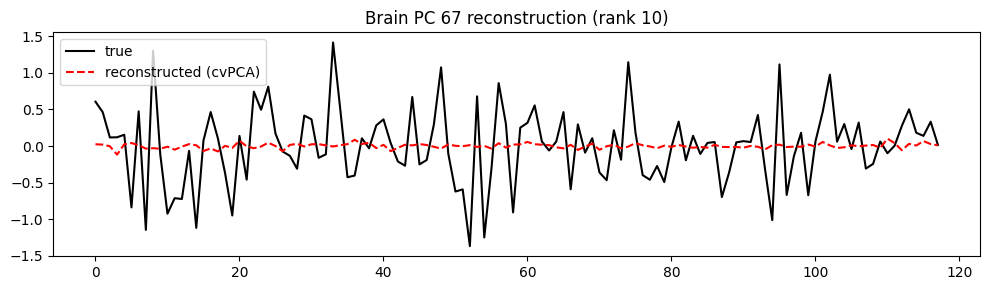

In [4]:
import matplotlib.pyplot as plt

# Visualize one random column (brain PC dimension)
j = np.random.randint(Zb.shape[1])
plt.figure(figsize=(10,3))
plt.title(f"Brain PC {j} reconstruction (rank {RANK})")
plt.plot(Zb[:, j], 'k-', label='true')
plt.plot(Zb_cv[:, j], 'r--', label='reconstructed (cvPCA)')
plt.legend()
plt.tight_layout()
plt.show()


In [5]:
corr = np.corrcoef(Zb[:, j], Zb_cv[:, j])[0, 1]
print(f"Correlation between true and reconstructed PC{j}: {corr:.3f}")


Correlation between true and reconstructed PC67: 0.015


Mean corr: 0.182244497356633


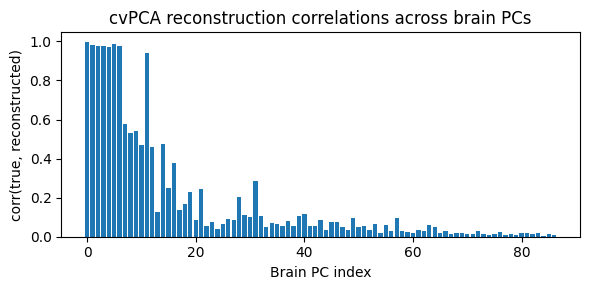

In [6]:
corrs = [np.corrcoef(Zb[:, j], Zb_cv[:, j])[0, 1] for j in range(Zb.shape[1])]
print("Mean corr:", np.mean(corrs))

plt.figure(figsize=(6,3))
plt.bar(np.arange(len(corrs)), corrs)
plt.xlabel("Brain PC index")
plt.ylabel("corr(true, reconstructed)")
plt.title("cvPCA reconstruction correlations across brain PCs")
plt.tight_layout()
plt.show()

🔹 Loading ViT embeddings...
✅ ViT PCs covering 90% variance: 44
🔹 Loading neural responses for VISp...
✅ VISp PCs covering 90% variance: 87
🔹 Running 25 bootstrap iterations with random missingness...
  Boot 01: mean col_corr=0.525, train=0.3597, test=0.4700
  Boot 02: mean col_corr=0.529, train=0.3618, test=0.4558
  Boot 03: mean col_corr=0.527, train=0.3629, test=0.4326
  Boot 04: mean col_corr=0.525, train=0.3550, test=0.5210
  Boot 05: mean col_corr=0.532, train=0.3667, test=0.3735
  Boot 06: mean col_corr=0.529, train=0.3611, test=0.4642
  Boot 07: mean col_corr=0.517, train=0.3608, test=0.5149
  Boot 08: mean col_corr=0.521, train=0.3623, test=0.4579
  Boot 09: mean col_corr=0.532, train=0.3590, test=0.4459
  Boot 10: mean col_corr=0.516, train=0.3614, test=0.4960
  Boot 11: mean col_corr=0.525, train=0.3618, test=0.4791
  Boot 12: mean col_corr=0.531, train=0.3580, test=0.4663
  Boot 13: mean col_corr=0.527, train=0.3567, test=0.4921
  Boot 14: mean col_corr=0.528, train=0.3615,

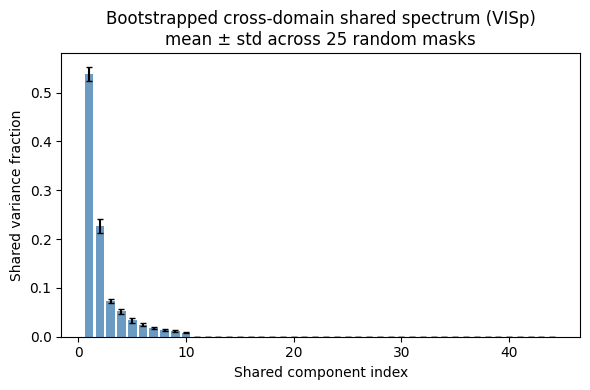

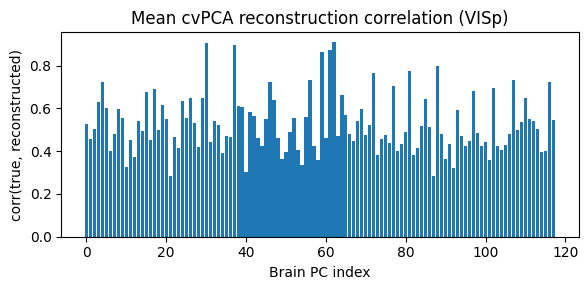

💾 Saved bootstrap results to vit_VISp_crossvalidated_alignment_bootstrap.npz


In [7]:
#!/usr/bin/env python3
"""
Bootstrapped cross-validated ViT–Brain alignment using random-mask cvPCA.

Each bootstrap iteration:
  - applies random missingness to brain PCs
  - reconstructs them using cvPCA (low-rank ALS)
  - computes the ViT–Brain cross-covariance singular values

Outputs:
  - mean ± std shared variance spectra across bootstraps
  - per-bootstrap reconstruction reliability
"""

import numpy as np
import pickle
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from scipy.special import softmax
from skbio.stats.composition import clr
from numpy.random import default_rng

# ---------------------------------------------------------------
# CONFIG
# ---------------------------------------------------------------
VIT_PATH    = '/home/maria/Documents/HuggingMouseData/MouseViTEmbeddings/google_vit-base-patch16-224_embeddings_logits.pkl'
NEURAL_PATH = '/home/maria/LuckyMouse/pixel_transformer_neuro/data/processed/hybrid_neural_responses.npy'
AREAS_PATH  = '/home/maria/MITNeuralComputation/visualization/brain_area.npy'
AREA_NAME   = 'VISp'

N_IMAGES, N_TRIALS = 118, 50
VAR_CUTOFF  = 0.90
P_HOLDOUT   = 0.1
N_BOOT      = 25          # number of bootstrap CV runs
RANK        = 10
N_ITER      = 20
RANDOM_SEED = 42
rng = default_rng(RANDOM_SEED)

# ---------------------------------------------------------------
# FUNCTIONS
# ---------------------------------------------------------------
def censored_lstsq(A, B, M, lam=1e-6):
    n, r = A.shape
    _, m = B.shape
    X = np.empty((r, m), dtype=B.dtype)
    I = np.eye(r, dtype=B.dtype)
    for j in range(m):
        mask = M[:, j]
        Aj = A[mask, :]
        bj = B[mask, j]
        T = Aj.T @ Aj + lam * I
        rhs = Aj.T @ bj
        X[:, j] = np.linalg.solve(T, rhs)
    return X

def random_mask_cvPCA(X, rank, p_holdout=0.1, n_iter=20, lam=1e-6, seed=0):
    """cvPCA with random missingness; returns reconstruction + reliability."""
    rng = default_rng(seed)
    n, m = X.shape
    M = rng.random((n, m)) > p_holdout
    U = rng.standard_normal((n, rank)) / np.sqrt(n)
    for _ in range(n_iter):
        V = censored_lstsq(U, X, M, lam=lam)
        UT = censored_lstsq(V.T, X.T, M.T, lam=lam)
        U = UT.T
    U, _, _ = np.linalg.svd(U, full_matrices=False)
    V = U.T @ X
    recon = U @ V
    train_err = np.mean(((recon - X)[M]) ** 2)
    test_err  = np.mean(((recon - X)[~M]) ** 2)
    # reliability per column (correlation true vs reconstructed)
    col_corr = [np.corrcoef(X[:, j], recon[:, j])[0, 1] for j in range(m)]
    return U, V, recon, M, np.mean(col_corr), train_err, test_err, col_corr

def crossdomain_svd(Zv, Zb):
    """Compute shared singular values between ViT and Brain representations."""
    Zv = Zv - Zv.mean(axis=0, keepdims=True)
    Zb = Zb - Zb.mean(axis=0, keepdims=True)
    C = (Zv.T @ Zb) / Zv.shape[0]
    U, S, Vt = np.linalg.svd(C, full_matrices=False)
    shared_var = S**2 / np.sum(S**2)
    return S, shared_var

# ---------------------------------------------------------------
# STEP 1: Load and preprocess ViT embeddings
# ---------------------------------------------------------------
print("🔹 Loading ViT embeddings...")
with open(VIT_PATH, 'rb') as f:
    vit_logits = pickle.load(f)['natural_scenes']  # (images × D_vit)
Xv = softmax(np.asarray(vit_logits), axis=1)
Xv = clr(Xv + 1e-12)

vit_pca_full = PCA(random_state=RANDOM_SEED).fit(Xv)
vit_cumvar = np.cumsum(vit_pca_full.explained_variance_ratio_)
vit_ncomp = np.searchsorted(vit_cumvar, VAR_CUTOFF) + 1
vit_pca = PCA(n_components=vit_ncomp, random_state=RANDOM_SEED)
Zv = vit_pca.fit_transform(Xv)
print(f"✅ ViT PCs covering 90% variance: {vit_ncomp}")

# ---------------------------------------------------------------
# STEP 2: Load neural data
# ---------------------------------------------------------------
print(f"🔹 Loading neural responses for {AREA_NAME}...")
dat = np.load(NEURAL_PATH, mmap_mode='r')
areas = np.load(AREAS_PATH, allow_pickle=True)
mask = (areas == AREA_NAME)
dat = dat[mask]

n_neurons, n_total = dat.shape
n_time = n_total // (N_IMAGES * N_TRIALS)
dat = dat.reshape(n_neurons, N_IMAGES, N_TRIALS, n_time)
X_mean = dat.mean(axis=(2,3))  # (neurons × images)

brain_pca_full = PCA(random_state=RANDOM_SEED).fit(X_mean.T)
brain_cumvar = np.cumsum(brain_pca_full.explained_variance_ratio_)
brain_ncomp = np.searchsorted(brain_cumvar, VAR_CUTOFF) + 1
brain_pca = PCA(n_components=brain_ncomp, random_state=RANDOM_SEED)
Zb = brain_pca.fit_transform(X_mean.T)  # (images × brain_ncomp)
print(f"✅ {AREA_NAME} PCs covering 90% variance: {brain_ncomp}")

# ---------------------------------------------------------------
# STEP 3: Bootstrap cvPCA + cross-domain covariance
# ---------------------------------------------------------------
all_spectra = []
all_corrs = []

print(f"🔹 Running {N_BOOT} bootstrap iterations with random missingness...")
for b in range(N_BOOT):
    seed = RANDOM_SEED + b
    Ub, Vb, Zb_cv, M, mean_corr, tr_err, te_err, col_corr = random_mask_cvPCA(
        Zb.T, rank=RANK, p_holdout=P_HOLDOUT, n_iter=N_ITER, seed=seed
    )
    S, shared_var = crossdomain_svd(Zv, Zb_cv.T)
    all_spectra.append(shared_var)
    all_corrs.append(col_corr)
    print(f"  Boot {b+1:02d}: mean col_corr={mean_corr:.3f}, train={tr_err:.4f}, test={te_err:.4f}")

all_spectra = np.array(all_spectra)
mean_spec = all_spectra.mean(axis=0)
std_spec = all_spectra.std(axis=0)

# ---------------------------------------------------------------
# STEP 4: Plot cross-domain shared variance spectrum
# ---------------------------------------------------------------
plt.figure(figsize=(6,4))
x = np.arange(1, len(mean_spec)+1)
plt.bar(x, mean_spec, yerr=std_spec, color='steelblue', alpha=0.8, capsize=2)
plt.xlabel("Shared component index")
plt.ylabel("Shared variance fraction")
plt.title(f"Bootstrapped cross-domain shared spectrum ({AREA_NAME})\nmean ± std across {N_BOOT} random masks")
plt.tight_layout()
plt.show()

# ---------------------------------------------------------------
# STEP 5: Plot mean reconstruction correlation across brain PCs
# ---------------------------------------------------------------
mean_corrs = np.mean(all_corrs, axis=0)
plt.figure(figsize=(6,3))
plt.bar(np.arange(len(mean_corrs)), mean_corrs)
plt.xlabel("Brain PC index")
plt.ylabel("corr(true, reconstructed)")
plt.title(f"Mean cvPCA reconstruction correlation ({AREA_NAME})")
plt.tight_layout()
plt.show()

# ---------------------------------------------------------------
# STEP 6: Save results
# ---------------------------------------------------------------
out = {
    "shared_spectra": all_spectra,
    "mean_spec": mean_spec,
    "std_spec": std_spec,
    "mean_corrs": mean_corrs
}
np.savez(f"vit_{AREA_NAME}_crossvalidated_alignment_bootstrap.npz", **out)
print(f"💾 Saved bootstrap results to vit_{AREA_NAME}_crossvalidated_alignment_bootstrap.npz")


In [8]:
import matplotlib.pyplot as plt
from PIL import Image
IMAGES_DIR='/home/maria/MITNeuralComputation/vit_embeddings/images'
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# ----------------------------------------------------------
# Compute shared scores per image
# ----------------------------------------------------------
vit_shared_scores   = Zv @ Ucv[:, 0]        # projection of each image in ViT space
brain_shared_scores = Zb_cv @ Vt_cv.T[:, 0] # projection in Brain space

# Normalize (optional)
vit_shared_scores   = (vit_shared_scores - vit_shared_scores.mean()) / vit_shared_scores.std()
brain_shared_scores = (brain_shared_scores - brain_shared_scores.mean()) / brain_shared_scores.std()

# ----------------------------------------------------------
# Rank images by the ViT projection (shared axis)
# ----------------------------------------------------------
idx_sorted = np.argsort(vit_shared_scores)
top10  = idx_sorted[-10:]
bot10  = idx_sorted[:10]

# ----------------------------------------------------------
# Visualization function
# ----------------------------------------------------------
#IMAGES_DIR = "/home/maria/Documents/HuggingMouseData/NaturalScenes"

def show_ranked_images(indices, title):
    plt.figure(figsize=(10, 2))
    for i, idx in enumerate(indices):
        img = Image.open(f"{IMAGES_DIR}/scene_{idx:03d}.png")
        plt.subplot(1, len(indices), i + 1)
        plt.imshow(img)
        plt.axis("off")
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

# ----------------------------------------------------------
# Show top/bottom images along shared axis
# ----------------------------------------------------------
show_ranked_images(top10, f"Top +10 images along shared PC1 ({AREA_NAME})")
show_ranked_images(bot10, f"Bottom −10 images along shared PC1 ({AREA_NAME})")



ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 87 is different from 118)

Zv: (118, 44)
Zb_cv: (87, 118)
Vt_cv: (44, 87)


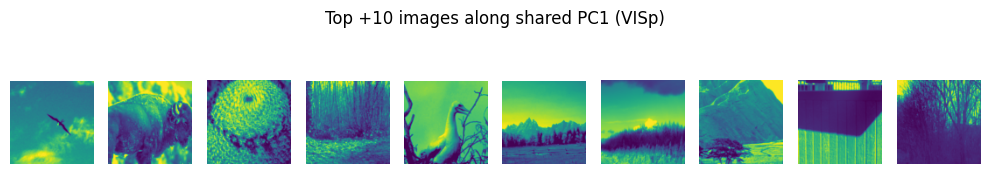

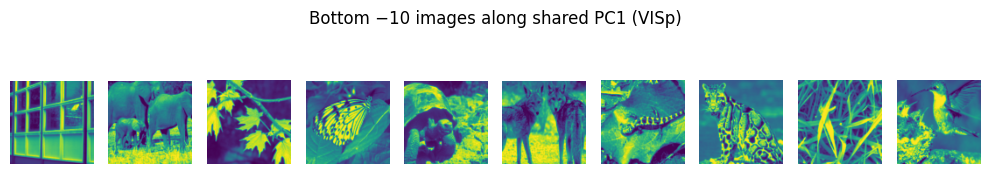

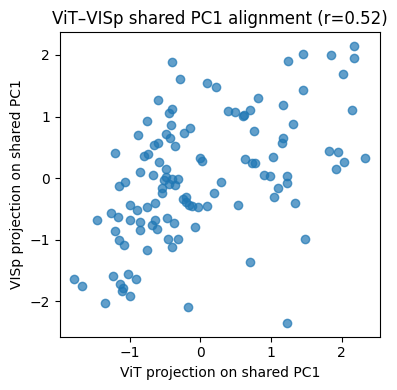

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

print("Zv:", Zv.shape)
print("Zb_cv:", Zb_cv.shape)
print("Vt_cv:", Vt_cv.shape)

# Compute shared scores
vit_shared_scores = Zv @ Ucv[:, 0]

if Zb_cv.shape[0] == Zv.shape[0]:
    brain_shared_scores = Zb_cv @ Vt_cv.T[:, 0]
else:
    brain_shared_scores = Zb_cv.T @ Vt_cv.T[:, 0]

# Normalize
vit_shared_scores   = (vit_shared_scores - vit_shared_scores.mean()) / vit_shared_scores.std()
brain_shared_scores = (brain_shared_scores - brain_shared_scores.mean()) / brain_shared_scores.std()

# Sort images by shared axis
idx_sorted = np.argsort(brain_shared_scores)
top10 = idx_sorted[-10:]
bot10 = idx_sorted[:10]

def show_ranked_images(indices, title):
    plt.figure(figsize=(10, 2))
    for i, idx in enumerate(indices):
        img = Image.open(f"{IMAGES_DIR}/scene_{idx:03d}.png")
        plt.subplot(1, len(indices), i + 1)
        plt.imshow(img)
        plt.axis("off")
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

# Plot images and scatter alignment
show_ranked_images(top10, f"Top +10 images along shared PC1 ({AREA_NAME})")
show_ranked_images(bot10, f"Bottom −10 images along shared PC1 ({AREA_NAME})")

r = np.corrcoef(vit_shared_scores, brain_shared_scores)[0,1]
plt.figure(figsize=(4,4))
plt.scatter(vit_shared_scores, brain_shared_scores, alpha=0.7)
plt.xlabel("ViT projection on shared PC1")
plt.ylabel(f"{AREA_NAME} projection on shared PC1")
plt.title(f"ViT–{AREA_NAME} shared PC1 alignment (r={r:.2f})")
plt.tight_layout()
plt.show()


In [10]:
import numpy as np, cv2
from PIL import Image

def spatial_frequency(img):
    arr = np.array(img)
    if arr.ndim == 3:
        gray = np.mean(arr, axis=2)     # RGB → grayscale
    else:
        gray = arr                      # already grayscale
    gray = gray.astype(float)
    f = np.fft.fftshift(np.fft.fft2(gray))
    freqs = np.abs(f)
    return np.mean(freqs)

# Compute spatial frequency energy for each image
energies = [spatial_frequency(Image.open(f"{IMAGES_DIR}/scene_{i:03d}.png")) for i in range(118)]

r_sf = np.corrcoef(energies, vit_shared_scores)[0,1]
print(f"Correlation between spatial frequency and shared PC1: r={r_sf:.2f}")


Correlation between spatial frequency and shared PC1: r=-0.28


In [ ]:
!pip install opencv-python

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.0/67.0 MB 16.4 MB/s eta 0:00:0000:0100:01
